# Interactive temperature and precipitation changes

The primary goal of this interactive widget notebook is to simulate and visualize how adjustments in statistical parameters affect climate-related data. In this notebook we use a delta approach for temperature data. While for precipitation we apply a quantile mapping approach where we change the mean and coefficient of variation (CV) of precipitation data. These changes can simulate the effect of changing climate conditions in the future.  By manipulating these parameters, users can gain insights into the effects of changes in each variable on the output time series.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma
import ipywidgets as widgets
from ipywidgets import VBox, HBox, Output
from IPython.display import display

## Applying Temperature Changes

we apply a simple delta factor to the original data. This involves adding or subtracting a constant value (delta) uniformly across the entire temperature time series. This method shifts the entire time series up or down by the specified delta, without altering the variability, distribution shape, or temporal structure of the data. This approach allows us to explore how a constant temperature change affects daily, seasonal, or annual trends, while keeping the overall pattern and variability intact. It’s a straightforward way to model uniform temperature changes.

In [9]:
# Set a random seed for reproducibility
np.random.seed(33)

# Generate random temperature data between -5 and 10 for 31 days
original_temperature = np.random.uniform(-5, 5, size=31)  # 31 data points

# Define Output widget for the plot
out_time_series = Output()

# Create slider for delta temperature adjustment
delta_slider = widgets.FloatSlider(
    value=4,
    min=-1,
    max=10,
    step=0.1,
    description='ΔT [°C]:',
    continuous_update=True  # Set to True for real-time updates
)

# Define the update function
def update_plot(change):
    delta = delta_slider.value

    with out_time_series:
        out_time_series.clear_output(wait=True)
        
        new_temperature = original_temperature + delta
        
        plt.figure(figsize=(10, 4))
        plt.plot(original_temperature, label='Original Temperature', alpha=0.7)
        plt.plot(new_temperature, label='Adjusted Temperature', alpha=0.7)
        plt.title('Original and Adjusted Temperature Time Series')
        plt.xlabel('Day')
        plt.ylabel('Temperature (°C)')
        plt.ylim([-7, 12])  # Set y-axis limits between -3 and 15
        plt.legend(loc='lower right')
        plt.show()

# Attach the update function to the slider
delta_slider.observe(update_plot, names='value')

# Initialize plot with default slider value
update_plot(None)

# Arrange the layout
combined_layout_temp = VBox([
    delta_slider,
    out_time_series
])

# Display the combined interactive plot
display(combined_layout_temp)


## Applying Precipitation changes

In this context, we are using quantile mapping with cumulative distribution functions (CDFs) to simulate changes in the distribution parameters of precipitation data by adjusting the mean or the coefficient of variation (CV) of an existing gamma distribution. The gamma distribution, often used for modeling precipitation, is characterized by its shape and scale parameters, which depend on the mean and CV.

To simulate an increase in the mean by 10%, we adjust the scale parameter (since the mean of a gamma distribution is the product of shape and scale), and map the original CDF to the new distribution. This shifts the CDF to the right, meaning that for the same cumulative probability, the precipitation values are higher. Conversely, changing the CV by 20% modifies both the shape and scale parameters, altering the spread of the distribution. A higher CV makes the CDF flatter, indicating increased variability and a higher likelihood of extreme precipitation events.

By applying quantile mapping, we transform the original precipitation CDF to reflect these changes, allowing us to visualize how increasing the mean or changing the CV impacts the overall distribution of rainfall, including its extremes and variability. This approach provides insight into how changes in climatic parameters, like increased precipitation or variability, could manifest in real-world scenarios. (Also see the figure below taken from [Steinschneider & Brown (2013)](https://doi.org/10.1002/wrcr.20528) as it illustrated the remapping procedure.)

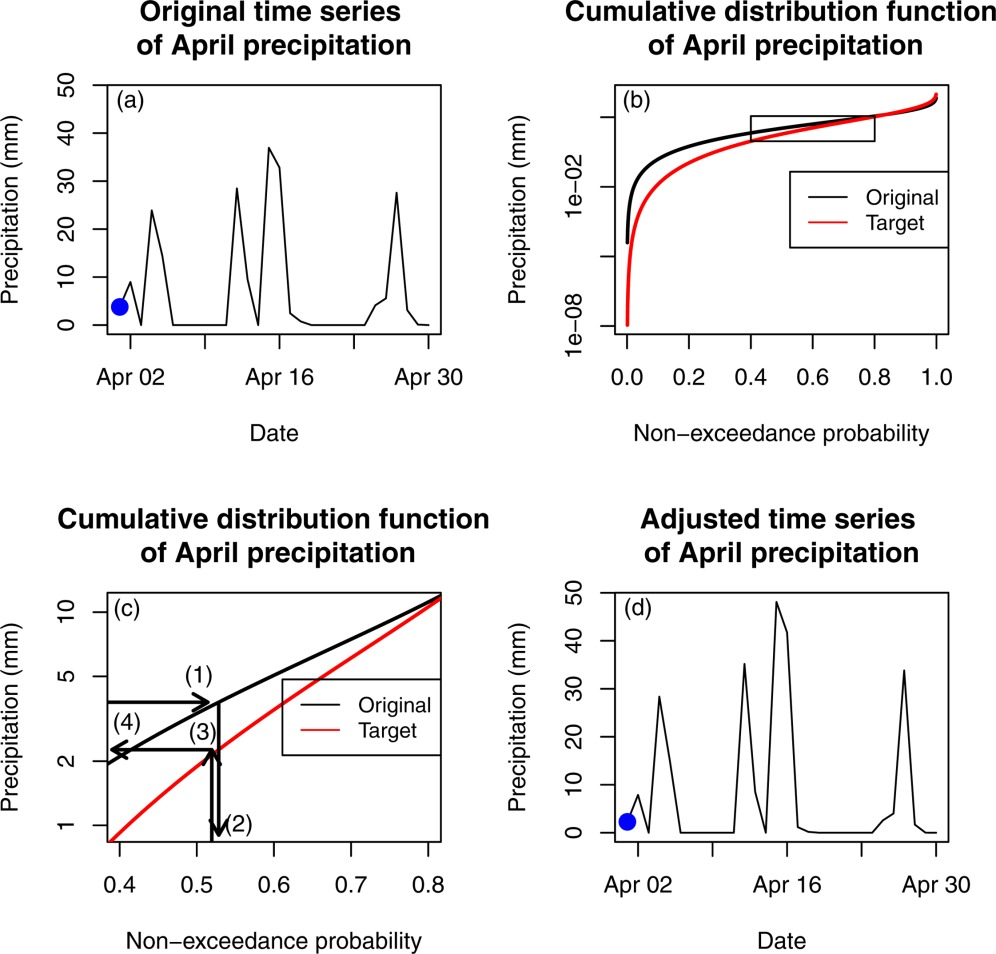

In [10]:
# Set a random seed for reproducibility
np.random.seed(33)

# Generate a fictive original rainfall time series according to a gamma distribution
mean1 = 0.35
CV1 = 0.4
shape = (mean1 / CV1) ** 2
scale = CV1 ** 2 / mean1
original_rainfall = gamma.rvs(a=shape, scale=scale, size=31*6)  # 186 data points

# Define Output widgets for the two plots
out_time_series = Output()
out_cdf = Output()

slider_layout = widgets.Layout(width='400px')
slider_style = {'description_width': '150px'}  # Increased from default


# Create shared sliders for mean and CV adjustments with increased width and description width
mean_slider = widgets.FloatSlider(
    value=40,
    min=-99,
    max=100,
    step=5,
    description='Mean Change [%]:',
    continuous_update=True,  # Set to True for real-time updates
    layout=slider_layout,
    style=slider_style
)

CV_slider = widgets.FloatSlider(
    value=60,
    min=-99,
    max=100,
    step=5,
    description='CV Change (%):',
    continuous_update=True,  # Set to True for real-time updates
    layout=slider_layout,
    style=slider_style
)

# Precompute constants that do not change
k1 = (mean1 / CV1) ** 2
theta1 = CV1 ** 2 / mean1
num_points_low = 700  # Number of points in lower range
num_points_high = 300  # Number of points in higher range
x_low = np.linspace(0, 2, num_points_low, endpoint=False)
x_high = np.linspace(2, 12.5, num_points_high)
x = np.concatenate([x_low, x_high])
# Define the update function
def update_plots(change):
    mean_percentage = mean_slider.value
    CV_percentage = CV_slider.value

    # Update Time Series plot
    with out_time_series:
        out_time_series.clear_output(wait=True)
        
        mean_multiplier = 1 + mean_percentage / 100
        CV_multiplier = 1 + CV_percentage / 100

        # Fit gamma distribution to original data
        shape_fit, loc, scale_fit = gamma.fit(original_rainfall)
        mean_fit = shape_fit * scale_fit
        CV_fit = 1 / np.sqrt(shape_fit)

        new_mean = mean_multiplier * mean_fit
        new_CV = CV_multiplier * CV_fit

        shape_parameter = 1 / new_CV**2
        scale_parameter = new_mean * new_CV**2

        gamma_scenario = gamma(a=shape_parameter, scale=scale_parameter)
        cdf_original = gamma.cdf(original_rainfall, a=shape_fit, scale=scale_fit)
        new_time_series = gamma_scenario.ppf(cdf_original)

        plt.figure(figsize=(10, 4))
        plt.plot(original_rainfall, label='Original Rainfall', alpha=0.7)
        plt.plot(new_time_series, label='New Rainfall (Adjusted)', alpha=0.7)
        plt.title('Original and Adjusted New Rainfall Time Series')
        plt.xlabel('Day')
        plt.ylabel('Rainfall (mm)')
        plt.ylim([0, 7])  # Adjusted to your preference
        plt.legend()
        plt.show()

    # Update CDF plot
    with out_cdf:
        out_cdf.clear_output(wait=True)
        
        new_mean_cdf = mean1 * (mean_percentage / 100 + 1)
        new_CV_cdf = CV1 * (CV_percentage / 100 + 1)
        k2 = (new_mean_cdf / new_CV_cdf) ** 2
        theta2 = new_CV_cdf ** 2 / new_mean_cdf

        # Precompute CDFs with reduced data points
        cdf1 = gamma.cdf(x, a=k1, scale=theta1)
        cdf2 = gamma.cdf(x, a=k2, scale=theta2)

        plt.figure(figsize=(8, 6))
        plt.plot(cdf1, x, label='Old CDF', alpha=0.7)
        plt.plot(cdf2, x, label='New CDF', alpha=0.7)
        plt.title('Gamma Cumulative Distribution Functions (CDFs)')
        plt.xlabel('Cumulative Probability')
        plt.ylabel('Rainfall (mm)')
        plt.xlim([0, 1])
        plt.yscale('log')
        plt.legend()
        plt.grid(True)
        plt.show()

# Attach the update function to the sliders
mean_slider.observe(update_plots, names='value')
CV_slider.observe(update_plots, names='value')

# Initialize plots with default slider values
update_plots(None)

# Arrange the layout
combined_layout = VBox([
    HBox([mean_slider, CV_slider], layout=widgets.Layout(justify_content='center', align_items='center')),
    HBox([out_time_series,out_cdf], layout=widgets.Layout(justify_content='center'))
])


# Display the combined interactive plot
display(combined_layout)

In [4]:
# 